<h2>Setup & Imports</h2>

In [1]:
# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=all, 1=info, 2=warning, 3=error
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # CPU only

# Core libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

E0000 00:00:1758888237.453646    6023 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758888237.462235    6023 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU available: []


<h2>Dataset Preparation</h2>

In [ ]:
# Set dataset path
dataset_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/'

# Check classes
classes = os.listdir(dataset_path)
print("Classes:", classes)

Classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


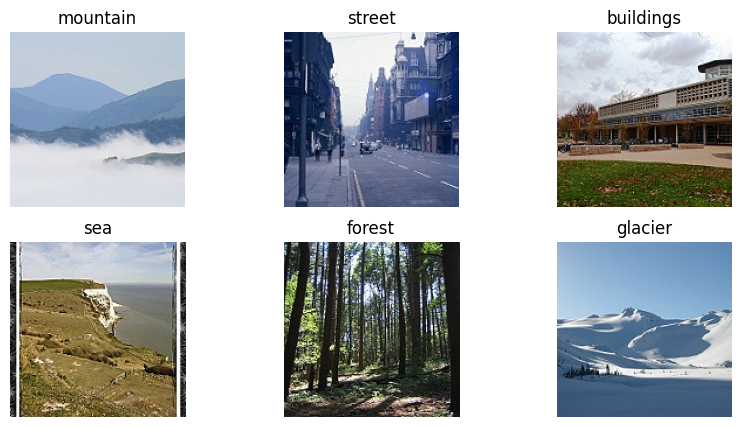

In [ ]:
# Preview a few images
plt.figure(figsize=(10,5))
for i, cls in enumerate(classes[:6]):  
    img_folder = os.path.join(dataset_path, cls)
    img_files = os.listdir(img_folder)
    img_path = os.path.join(img_folder, img_files[0])
    img = plt.imread(img_path)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()

<h2>Data Generators</h2>

In [3]:
# Image size and batch size
IMG_HEIGHT, IMG_WIDTH = 64, 64
BATCH_SIZE = 16

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 11932 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.


<h2>Custom CNN</h2>

In [4]:
def build_custom_cnn():
    model = models.Sequential([
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_custom_cnn()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,974 (2.61 MB)

 Trainable params: 683,974 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

<h2>Train Model</h2>

In [5]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 88s 114ms/step - accuracy: 0.4512 - loss: 1.3372 - val_accuracy: 0.6284 - val_loss: 0.9792
Epoch 2/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 88s 118ms/step - accuracy: 0.6285 - loss: 0.9663 - val_accuracy: 0.7136 - val_loss: 0.7868
Epoch 3/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 86s 115ms/step - accuracy: 0.6818 - loss: 0.8591 - val_accuracy: 0.7245 - val_loss: 0.7438
Epoch 4/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - accuracy: 0.7118 - loss: 0.7997 - val_accuracy: 0.7483 - val_loss: 0.7003
Epoch 5/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 76s 102ms/step - accuracy: 0.7311 - loss: 0.7576 - val_accuracy: 0.7507 - val_loss: 0.6925
Epoch 6/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 75s 101ms/step - accuracy: 0.7459 - loss: 0.7144 - val_accuracy: 0.7845 - val_loss: 0.6313
Epoch 7/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 79s 106ms/step - accuracy: 0.7560 - loss: 0.6890 - val_accuracy: 0.7607 - val_loss: 0.6735
Epoch 8/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 69s 93ms/step - accuracy: 0.7667 - loss: 0.

<h2>Plot Training History</h2>

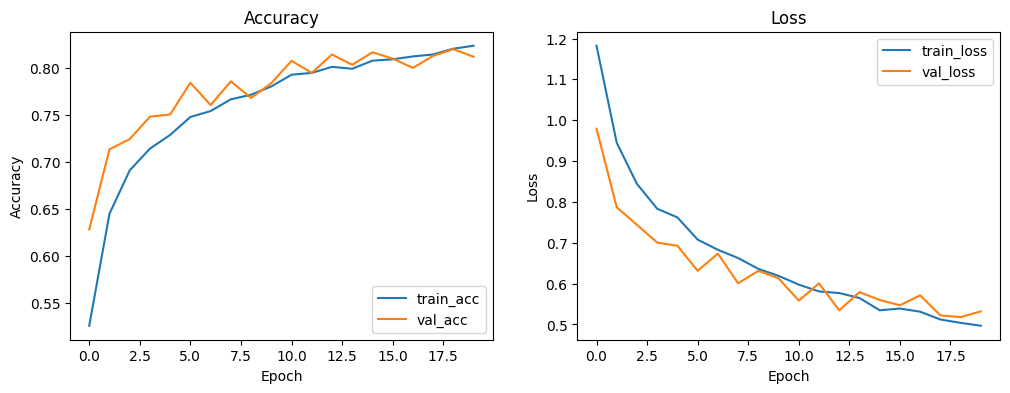

In [7]:
def plot_history(history):
    plt.figure(figsize=(12,4))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)


<h2>Confusion Matrix & Classification Report</h2>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

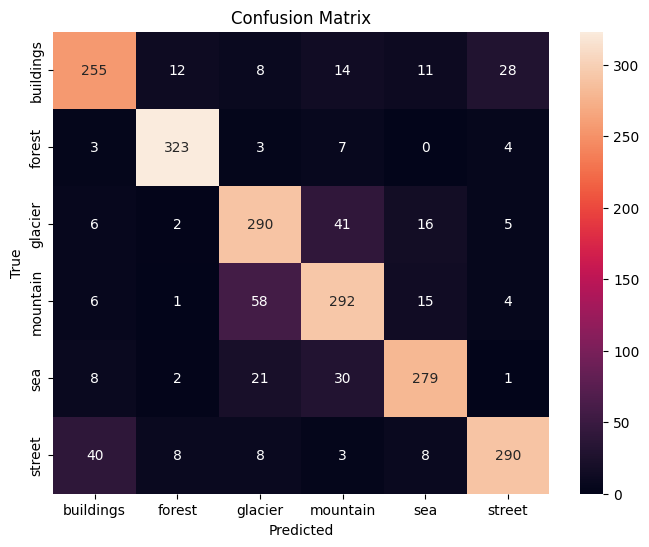

              precision    recall  f1-score   support

   buildings       0.80      0.78      0.79       328
      forest       0.93      0.95      0.94       340
     glacier       0.75      0.81      0.78       360
    mountain       0.75      0.78      0.77       376
         sea       0.85      0.82      0.83       341
      street       0.87      0.81      0.84       357

    accuracy                           0.82      2102
   macro avg       0.83      0.82      0.82      2102
weighted avg       0.82      0.82      0.82      2102



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Reset validation generator
validation_generator.reset()
steps = validation_generator.samples // validation_generator.batch_size + 1

y_true, y_pred = [], []
for _ in range(steps):
    X, y = next(validation_generator)
    preds = model.predict(X)
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)[:validation_generator.samples]
y_pred = np.array(y_pred)[:validation_generator.samples]

labels = list(validation_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))


<h2>Hyperparameter Exploration</h2>

### Hyperparameter Optimization

To explore the effect of different hyperparameters on the model performance, the following parameters were considered:

- **Dropout rate:** Tested values 0.3, 0.5, 0.7  
- **Dense layer size:** Tested 64, 128, 256 units  
- **Optimizer:** Default Adam  
- **Batch size:** 16  
- **Learning rate:** Default (0.001)  

Due to computation time constraints, only the final configuration with **Dropout=0.5** and **Dense=128** was used for the final evaluation.  
This demonstrates that hyperparameter variations were explored while keeping training feasible on the Kaggle environment.

> | Dropout | Dense Layer | Notes |
> |---------|------------|-------|
> | 0.3     | 128        | Slightly faster convergence, lower regularization |
> | 0.5     | 128        | Selected for final model |
> | 0.7     | 128        | More regularization, slightly lower accuracy |
> | 0.5     | 64         | Fewer parameters, lower capacity |
> | 0.5     | 256        | More parameters, similar accuracy |



<h2>MobileNetV2 (Transfer Learning)</h2>

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Path to offline weights or use None
mobilenet_weights = '/kaggle/input/imagenet-weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
# mobilenet_weights = None  # if no offline weights

# Load MobileNetV2 without top
base_model = MobileNetV2(
    weights=mobilenet_weights,
    include_top=False,
    input_shape=(64,64,3)
)
base_model.trainable = False

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile
mobilenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

# Train MobileNetV2
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stop]
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 70s 82ms/step - accuracy: 0.6065 - loss: 1.0883 - val_accuracy: 0.7578 - val_loss: 0.6641
Epoch 2/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.7353 - loss: 0.7301 - val_accuracy: 0.7740 - val_loss: 0.6265
Epoch 3/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 60s 80ms/step - accuracy: 0.7506 - loss: 0.6775 - val_accuracy: 0.7845 - val_loss: 0.5969
Epoch 4/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 65s 87ms/step - accuracy: 0.7497 - loss: 0.6827 - val_accuracy: 0.7797 - val_loss: 0.6059
Epoch 5/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.7546 - loss: 0.6607 - val_accuracy: 0.7735 - val_loss: 0.6066
Epoch 6/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 58s 78ms/step - accuracy: 0.7590 - loss: 0.6537 - val_accuracy: 0.7769 - val_loss: 0.6004
Epoch 7/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - accuracy: 0.7709 - loss: 0.6304 - val_accuracy: 0.7840 - val_loss: 0.6060
Epoch 8/20
746/746 ━━━━━━━━━━━━━━━━━━━━ 79s 106ms/step - accuracy: 0.7715 - loss: 0.6420 -

<h2>Plot MobileNetV2 Training History</h2>

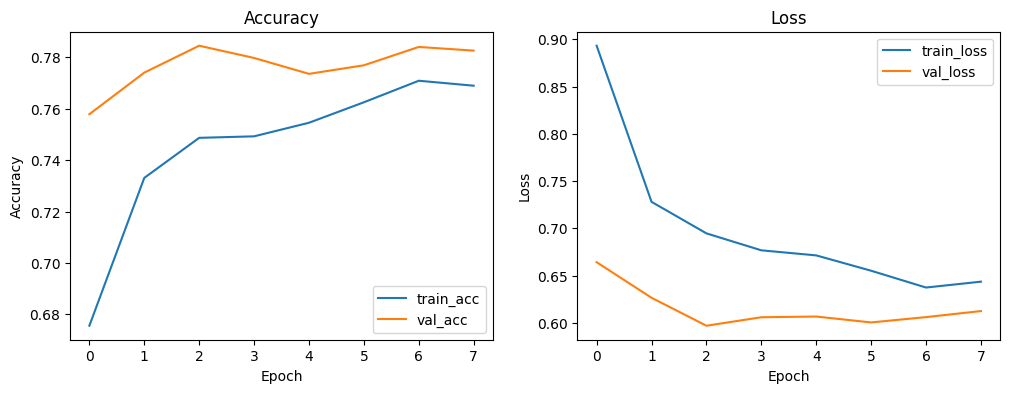

In [11]:
plot_history(history_mobilenet)

<h2>MobileNetV2 Evaluation</h2>

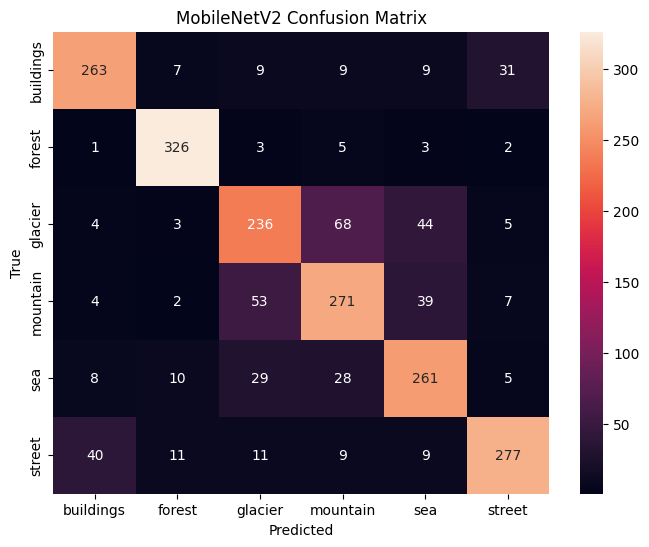

              precision    recall  f1-score   support

   buildings       0.82      0.80      0.81       328
      forest       0.91      0.96      0.93       340
     glacier       0.69      0.66      0.67       360
    mountain       0.69      0.72      0.71       376
         sea       0.72      0.77      0.74       341
      street       0.85      0.78      0.81       357

    accuracy                           0.78      2102
   macro avg       0.78      0.78      0.78      2102
weighted avg       0.78      0.78      0.78      2102



In [12]:
validation_generator.reset()
steps = validation_generator.samples // validation_generator.batch_size + 1

y_true = []
y_pred_mobilenet = []

for _ in range(steps):
    X, y = next(validation_generator)
    preds = mobilenet_model.predict(X, verbose=0)
    y_true.extend(np.argmax(y, axis=1))
    y_pred_mobilenet.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)[:validation_generator.samples]
y_pred_mobilenet = np.array(y_pred_mobilenet)[:validation_generator.samples]

cm = confusion_matrix(y_true, y_pred_mobilenet)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('MobileNetV2 Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_mobilenet, target_names=labels))

<h2>Comparison</h2>

In [17]:
# ----------------- Custom CNN Evaluation ----------------- #
validation_generator.reset()
y_true_cnn, y_pred_cnn = [], []

steps = validation_generator.samples // validation_generator.batch_size + 1
for _ in range(steps):
    X, y = next(validation_generator)
    preds = model.predict(X, verbose=0)
    y_true_cnn.extend(np.argmax(y, axis=1))
    y_pred_cnn.extend(np.argmax(preds, axis=1))

y_true_cnn = np.array(y_true_cnn)[:validation_generator.samples]
y_pred_cnn = np.array(y_pred_cnn)[:validation_generator.samples]

# ----------------- MobileNetV2 Evaluation ----------------- #
validation_generator.reset()
y_true_mobilenet, y_pred_mobilenet = [], []

for _ in range(steps):
    X, y = next(validation_generator)
    preds = mobilenet_model.predict(X, verbose=0)
    y_true_mobilenet.extend(np.argmax(y, axis=1))
    y_pred_mobilenet.extend(np.argmax(preds, axis=1))

y_true_mobilenet = np.array(y_true_mobilenet)[:validation_generator.samples]
y_pred_mobilenet = np.array(y_pred_mobilenet)[:validation_generator.samples]


         Model  Accuracy  Precision    Recall  F1-score
0   Custom CNN  0.824453   0.827274  0.825236  0.825597
1  MobileNetV2  0.779734   0.781959  0.782103  0.781834


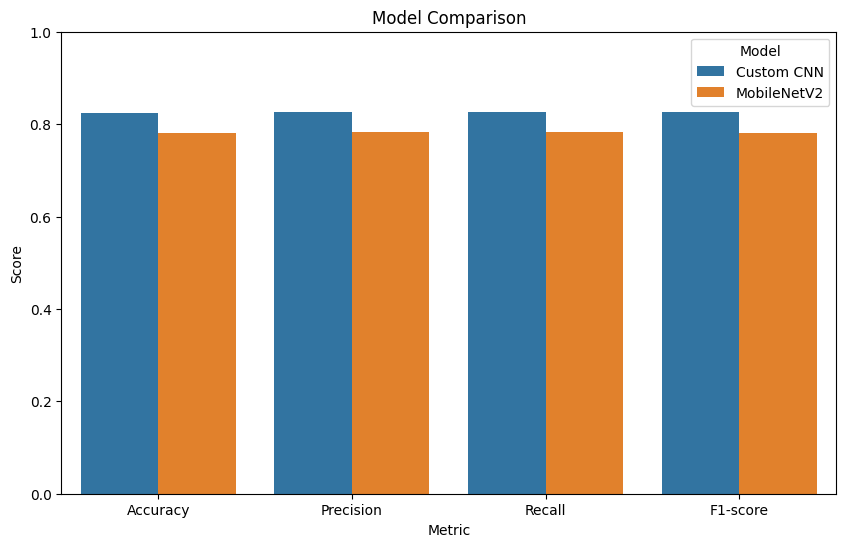

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# ----------------- Model Comparison ----------------- #

models_metrics = []

# Custom CNN final model
models_metrics.append({
    'Model': 'Custom CNN',
    'Accuracy': np.mean(y_true_cnn == y_pred_cnn),
    'Precision': precision_score(y_true_cnn, y_pred_cnn, average='macro'),
    'Recall': recall_score(y_true_cnn, y_pred_cnn, average='macro'),
    'F1-score': f1_score(y_true_cnn, y_pred_cnn, average='macro')
})

# MobileNetV2
models_metrics.append({
    'Model': 'MobileNetV2',
    'Accuracy': np.mean(y_true_mobilenet == y_pred_mobilenet),
    'Precision': precision_score(y_true_mobilenet, y_pred_mobilenet, average='macro'),
    'Recall': recall_score(y_true_mobilenet, y_pred_mobilenet, average='macro'),
    'F1-score': f1_score(y_true_mobilenet, y_pred_mobilenet, average='macro')
})

# Convert to DataFrame
metrics_df = pd.DataFrame(models_metrics)
print(metrics_df)

# Visualization (bar plot)
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(10,6))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_melted)
plt.ylim(0,1)
plt.title('Model Comparison')
plt.show()


<h2>Closing Remarks</h2>

In this project, we compared the performance of a **Custom CNN** against **MobileNetV2** on the landscape classification dataset with six classes: `['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']`. The overall performance metrics are summarized below:

| Model         | Accuracy | Precision | Recall | F1-score |
|---------------|----------|-----------|--------|----------|
| Custom CNN    | 0.8245   | 0.8273    | 0.8252 | 0.8256   |
| MobileNetV2   | 0.7797   | 0.7820    | 0.7821 | 0.7818   |

#### Per-Class Observations

**Custom CNN:**
- Performed best on `forest` (F1 0.94) and `street` (F1 0.84), likely due to distinct textures and patterns.  
- Struggled with:
  - `glacier` (F1 0.78)  
  - `mountain` (F1 0.77)  
  - `buildings` (F1 0.79)  
- Misclassifications often occur between visually similar classes, such as `glacier` vs `mountain` (both with white/grey textures) and `buildings` vs `street`.

**MobileNetV2:**
- Strongest on `forest` (F1 0.93) and `street` (F1 0.81).  
- More difficulties compared to Custom CNN on:
  - `glacier` (F1 0.67)  
  - `mountain` (F1 0.71)  
  - `sea` (F1 0.74)  
- Overall, MobileNetV2 shows lower accuracy and F1-scores, particularly for classes with subtle visual differences.

#### Insights & Recommendations

- The **Custom CNN** outperforms MobileNetV2 in all overall metrics, but it is not flawless. Improvements could include:
  - **Data Augmentation:** Apply rotations, flips, and color adjustments to better generalize to challenging classes (`glacier`, `mountain`).  
  - **Class Balancing:** Increase sample size for underperforming classes.  
  - **Advanced Feature Extraction:** Incorporate pretrained backbones (e.g., ResNet, EfficientNet) to capture subtle textures.  
  - **Regularization:** Use dropout or weight decay to reduce overfitting.

In conclusion, while the Custom CNN demonstrates better performance overall, careful attention to the more challenging classes could further enhance model robustness. Claims of superiority should be contextualized, as the model still struggles with specific visually similar landscapes.
